In [408]:
import sys,os
sys.path.append('..')
sys.path.append('../..')
from backtester import matlab, backtester
from backtester.analysis import *
from backtester.swarms.swarm import Swarm
from backtester.exoinfo import EXOInfo
from exobuilder.data.exostorage import EXOStorage
from IPython.core.display import display, HTML

from sklearn import linear_model, cross_validation, naive_bayes, ensemble, tree, neighbors, cluster, preprocessing

import pandas as pd
import numpy as np
import scipy
import pprint

import glob
from pandas.tseries.offsets import *

In [409]:
%pylab inline
%load_ext autoreload
%autoreload 2

figsize(20,10)

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Rng strategies

In [410]:
#
# random time series
#
df = pd.DataFrame()
for i in range(1000):
    
    date = pd.date_range(start='2015-01', end='2016-10', freq='D')
    price = np.random.randint(-100, 101, size=len(date))
    
    ser = pd.Series(price, index=date, name='rng_system'+str(i))
    df['rng_system'+str(i)] = ser.cumsum()

# Set EXO name here

[   'ES_BullishCollarBW',
    'ES_BearishCollarBW',
    'ES_CallSpread',
    'ES_PutSpread',
    'CL_BullishCollarBW',
    'CL_BearishCollarBW',
    'CL_CallSpread',
    'CL_PutSpread',
    'NG_BullishCollarBW',
    'NG_BearishCollarBW',
    'NG_CallSpread',
    'NG_PutSpread',
    'ES_ContFut',
    'NG_ContFut',
    'CL_ContFut',
    'ZN_ContFut']


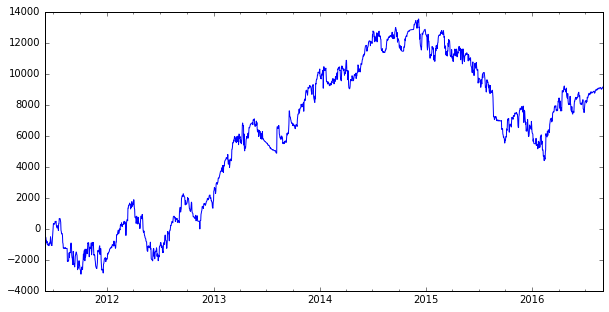

In [396]:
# Loading global setting for MongoDB etc.
from scripts.settings import *

try:
    from scripts.settings_local import *
except:
    pass

storage = EXOStorage(MONGO_CONNSTR, MONGO_EXO_DB)
pp = pprint.PrettyPrinter(indent=4)

exo_list = storage.exo_list()
pp.pprint(exo_list)


exo_series, exo_dict = storage.load_series('ES_CallSpread')
exo_series = exo_series[exo_series.columns[0]]

exo_series.plot()

# Saved Swarm universes as input

In [574]:
df = pd.DataFrame()
exoname = 'ES'
direction = 'Long' # Long short
exostrategy = 'PutSpread' # CallSpread .. etc

for file in glob.glob("../swarms/*.swm"):
    swarmname = file.split('/')[-1]
    
    if (exoname in swarmname) and (direction in swarmname) and (exostrategy in swarmname):
        if df.size == 0:
            df = Swarm.load('../swarms/'+swarmname).raw_swarm
        else:
            df = pd.concat([df, Swarm.load('../swarms/'+swarmname).raw_swarm], axis=1)
    #print(file.split('/')[-1])
    #break
    
df = df.dropna(how='all')

## Single swarm

In [149]:

# set file name here
swarm_file = 'CL_CallSpread_Short_RenkoPatterns_no_exit_on_patterns'

# Real swarm from .swm
df = Swarm.load('../swarms/'+swarm_file+'.swm').raw_swarm
#df = df

# Alphas

In [562]:
instruments_filter = ['ES']  # Select ALL
#instruments_filter = ['ES']

exo_filter = ['*'] # Select ALL
#exo_filter = ['CallSpread']

#direction_filter = [0, -1, 1] # Select ALL
direction_filter = [-1]

alpha_filter = ['*']  # Select ALL
#alpha_filter = ['MaCross', 'PointAndFigurePatterns']

swmdf, swm_data = storage.swarms_list(instruments_filter, direction_filter, alpha_filter, exo_filter)

df = swmdf

In [563]:
#swarm = Swarm.load('../swarms/'+swarm_file+'.swm')

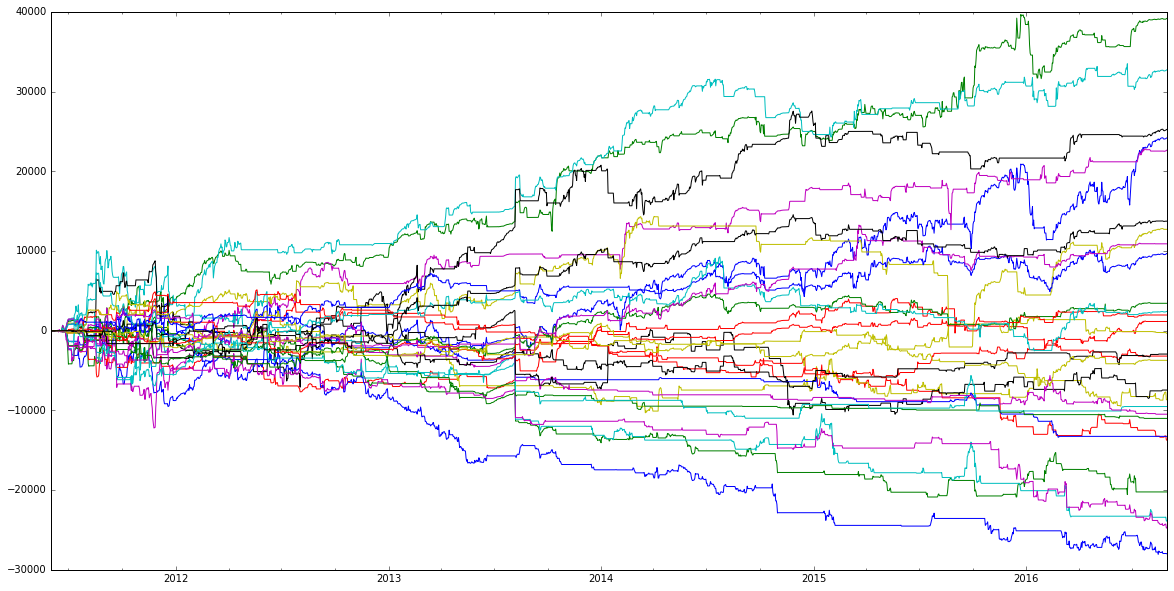

In [564]:
df.plot(legend=False)

## Systems overall performance estimation

In [581]:
temp_l = []

dynamic_exo_selection_flag = True

for strat in df.columns:
        input_strategy_data = df[strat] # This data is used in metrics calc
        
        if dynamic_exo_selection_flag == True:
            
            # Dynamic EXO selection
            try:
                exo_series, exo_dict = storage.load_series(strat.split('_')[0]+'_'+strat.split('_')[1])
                exo_series = exo_series[exo_series.columns[0]]

            except IndexError:
                print('Seems like a swarm universes or single swarm are used as input. Dynamic EXO selection is disabled. Select a proper EXO series in the block above')
                dynamic_exo_selection_flag = False
        
        
        price_change = input_strategy_data.diff()
        max_dd = (input_strategy_data - input_strategy_data.expanding().max()).min()
        netprofit = df[strat].ix[-1] - df[strat].ix[0]

        # Since swarm PnL statistics is not trade-by-trade
        # For PF calc I used cumulative values of positive and negatives price changes
        # Same for winrate
        profit_factor = price_change[price_change > 0].sum() / np.abs(price_change[price_change < 0].sum())

        winrate = (price_change[price_change > 0].count() / price_change.count()) * 100               

        try:
            modsharpe = np.mean(price_change) / np.std(price_change)

        except ZeroDivisionError:
            modsharpe = np.nan
        
        strategy_pctchange = input_strategy_data.pct_change(1).replace([np.inf, -np.inf], np.nan)
        exo_series_pctchange = exo_series.pct_change(1).replace([np.inf, -np.inf], np.nan)


        strategy_pos_pctchange = strategy_pctchange[strategy_pctchange > 0]
        exo_series_pos_pctchange = exo_series_pctchange[exo_series_pctchange > 0]

        strategy_neg_pctchange = strategy_pctchange[strategy_pctchange < 0]
        exo_series_neg_pctchange = exo_series_pctchange[exo_series_pctchange < 0]
        
        try:
            d = {'strategy': strat,
                'stats_pricechange_modsharpe': modsharpe.values[0],
                'stats_up_beta': strategy_pos_pctchange.ix[:,0].cov(exo_series_pos_pctchange) / exo_series_pos_pctchange.var(),
                'stats_down_beta': strategy_neg_pctchange.ix[:,0].cov(exo_series_neg_pctchange) / exo_series_neg_pctchange.var(),
                #'stats_netprofit': netprofit,
                #'stats_max_dd': max_dd, 
                'stats_recovery_factor': (netprofit / np.abs(max_dd)).values[0],
                'stats_profit_factor': (profit_factor).values[0]
                 }
                 #'stats_winrate': winrate }

            temp_l.append(d)
        
        except:
            d = {'strategy': strat,
                'stats_pricechange_modsharpe': modsharpe,
                'stats_up_beta': strategy_pos_pctchange.cov(exo_series_pos_pctchange) / exo_series_pos_pctchange.var(),
                'stats_down_beta': strategy_neg_pctchange.cov(exo_series_neg_pctchange) / exo_series_neg_pctchange.var(),
                #'stats_netprofit': netprofit,
                #'stats_max_dd': max_dd, 
                'stats_recovery_factor': (netprofit / np.abs(max_dd)),
                'stats_profit_factor': (profit_factor)
                 }
                 #'stats_winrate': winrate }

            temp_l.append(d)
            
        #print(strat.split('_')[0]+'_'+strat.split('_')[1])

Seems like a swarm universes or single swarm are used as input. Dynamic EXO selection is disabled. Select a proper EXO series in the block above


/usr/local/lib/python3.5/dist-packages/numpy/lib/function_base.py:2487: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


In [566]:
strategies_performance_df = pd.DataFrame(temp_l).dropna()
strategies_performance_df['rating'] = np.zeros_like(len(strategies_performance_df))

strategies_performance_df['stats_betas_ratio'] = strategies_performance_df.stats_up_beta / strategies_performance_df.stats_down_beta
strategies_performance_df['stats_betas_difference'] = strategies_performance_df.stats_up_beta - strategies_performance_df.stats_down_beta

strategies_performance_df.set_index('strategy', inplace=True)

strategies_performance_df = pd.DataFrame(preprocessing.scale(strategies_performance_df), index=strategies_performance_df.index,
                                         columns=strategies_performance_df.columns)

#strategies_performance_df.stats_profit_factor.plot()

# Rating
# Proceed to the next block if you already have a dataset 

In [109]:
#
# 1) Pick a random equity
#
figsize(10,5)

sample = strategies_performance_df[strategies_performance_df.rating == 0].sample(1)

print('Up Beta',sample.stats_up_beta.values[0])
print('Down Beta',sample.stats_down_beta.values[0])
print('------------------------------Betas ratio',sample.stats_betas_ratio.values[0])
print('------------------------------Betas diff',sample.stats_betas_difference.values[0])

df[sample.index].plot()
exo_series.plot(legend='EXO')

AttributeError: 'DataFrame' object has no attribute 'rating'

In [529]:
#
# 2) Rate this equity from 1 to 5 in a field below. Repeat
#
rating = input('Rate this equity from 1 to 5 -- ')

while True:
    
    try:
        if (int(rating) > 0 and int(rating) <= 5):
            strategies_performance_df.loc[strategies_performance_df.index.isin(sample.index), 'rating'] = int(rating)
            break
        else:
            print('Invalid value!')
            rating = input('Rate this equity from 1 to 5 -- ')
            
    except:
        print('Invalid value!')
        rating = input('Rate this equity from 1 to 5 -- ')

Rate this equity from 1 to 5 -- 4


In [530]:
#
# 3) Run this block to see your dataset
#
print(strategies_performance_df[strategies_performance_df.rating != 0].drop('rating', 1).shape)
strategies_performance_df[strategies_performance_df.rating != 0]

(80, 7)


,stats_down_beta,stats_pricechange_modsharpe,stats_profit_factor,stats_recovery_factor,stats_up_beta,rating,stats_betas_ratio,stats_betas_difference
strategy,,,,,,,,
"(1, 1, 6, 5)",-0.132399,0.006753,0.540569,0.586800,-0.147182,4.0,0.569205,-0.014783
"(1, 11, 10, 5)",-0.027490,0.011149,0.583929,0.646515,-0.025160,4.0,0.489415,0.002330
"(1, 12, 5, 5)",-0.018240,0.008846,0.417607,0.568346,-0.034164,5.0,0.707640,-0.015924
"(1, 13, 1, 5)",-0.035640,0.012116,0.394079,0.622568,-0.069660,5.0,0.670585,-0.034019
"(1, 14, 3, 5)",-0.118813,0.017618,0.597971,0.671149,-0.092925,5.0,0.410192,0.025888
"(1, 19, 4, 5)",-0.249125,0.021885,0.562190,0.743876,-0.102588,5.0,0.189873,0.146537
"(1, 19, 9, 5)",-0.010474,0.005258,0.341173,0.335797,-0.028810,5.0,0.877233,-0.018337
"(1, 2, 6, 5)",-0.286178,0.005165,0.455829,0.323840,-0.421642,5.0,0.639758,-0.135464
"(1, 24, 2, 5)",-0.011614,0.011458,0.347681,0.660181,-0.026058,5.0,0.664925,-0.014444


In [532]:
#
# 4) If you satisfied with a dataset - Uncomment to save dataset
# ! This will overwrite an existing dataset
#
#strategies_performance_df[strategies_performance_df.rating != 0].to_csv('dataset.csv')

# Clustering by all performance stats series

In [567]:
clustering_model = cluster.KMeans(n_clusters=5, precompute_distances=True)
clustering_model.fit(strategies_performance_df.as_matrix())

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=10,
    n_jobs=1, precompute_distances=True, random_state=None, tol=0.0001,
    verbose=0)

In [568]:
strategies_performance_df['cluster'] = clustering_model.labels_

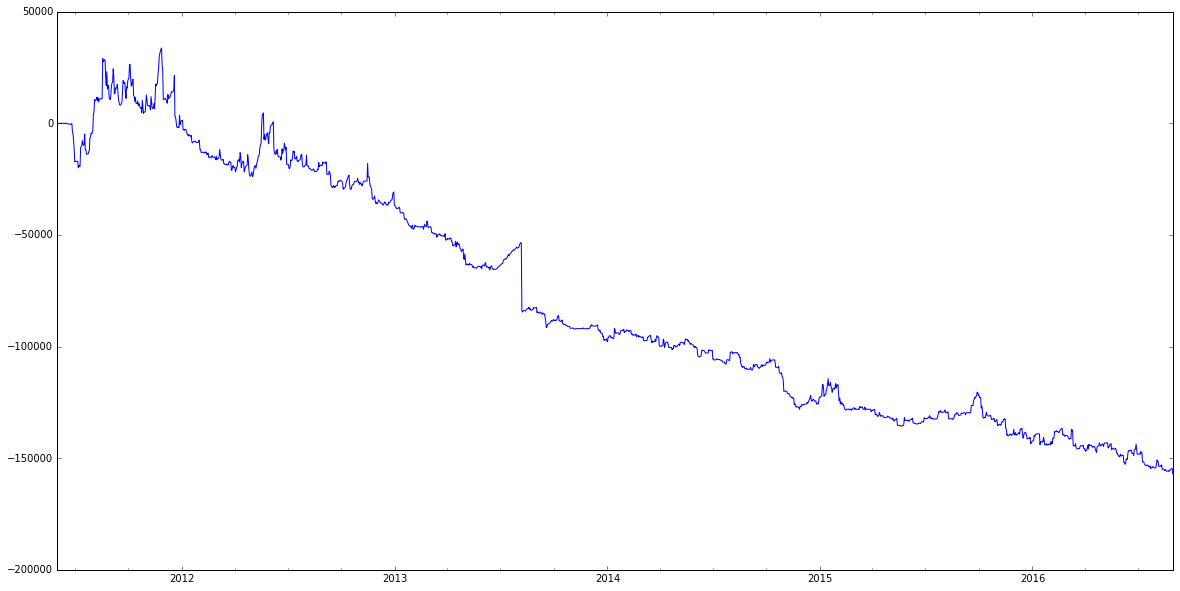

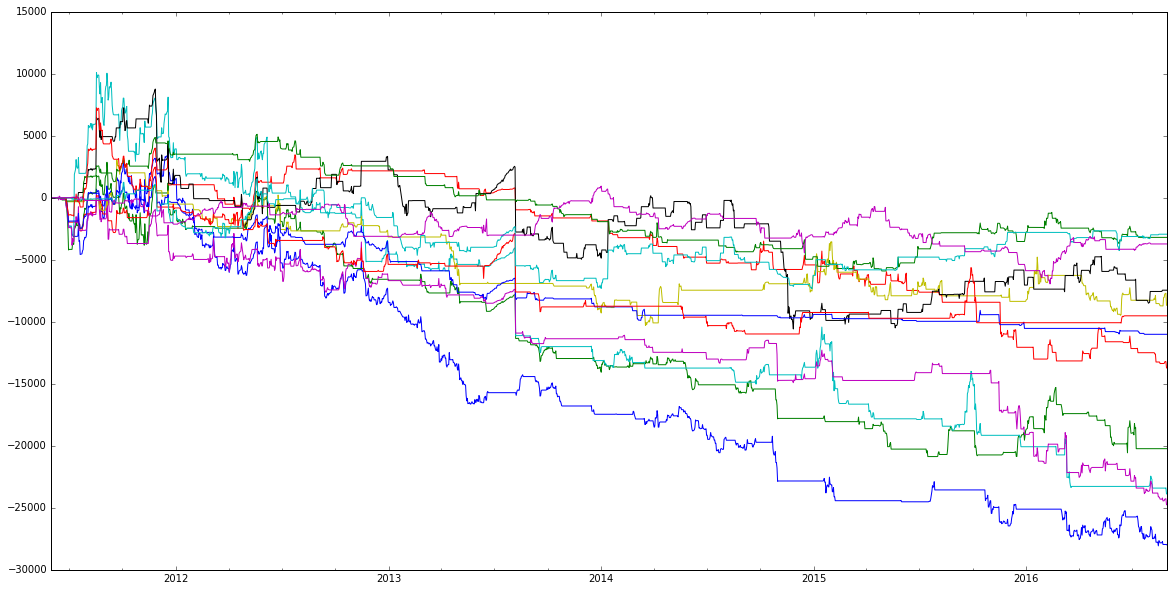

In [573]:
#exo_series.plot(kind='area',legend='EXO', stacked=False, secondary_y=True)
df[strategies_performance_df[strategies_performance_df.cluster == 1].index].sum(1).plot(legend=False)
df[strategies_performance_df[strategies_performance_df.cluster == 1].index].plot(legend=False)

# Clustering every performance stats metrics separately

In [248]:
clustering_model = cluster.KMeans(n_clusters=10, precompute_distances=True)

for i in strategies_performance_df.columns:
    strategies_performance_df[i+'_cluster'] = clustering_model.fit_predict(strategies_performance_df[i].values.reshape(-1, 1))
    
    strategies_performance_df[i+'_clustercenter'] = np.zeros_like(strategies_performance_df.stats_pricechange_modsharpe)
    
    for cc in range(len(clustering_model.cluster_centers_)):
        strategies_performance_df.loc[strategies_performance_df[i+'_cluster'] == cc,
                                      i+'_clustercenter'] = clustering_model.cluster_centers_[cc] 

In [249]:
clusters_rank_d = {}
for i in strategies_performance_df.columns:
    if 'cluster' not in i:
        clusters_rank_d[i] = strategies_performance_df.sort_values(i+'_clustercenter', ascending=False)[i+'_cluster'].unique()

In [250]:
clusters_rank_d

{'stats_betas_difference': array([9, 4, 3, 8, 0, 7, 1, 5, 2, 6]),
 'stats_betas_ratio': array([0, 4, 7, 8, 3, 2, 5, 9, 6, 1]),
 'stats_down_beta': array([3, 6, 1, 5, 2, 4, 7, 9, 0, 8]),
 'stats_pricechange_modsharpe': array([6, 1, 5, 3, 7, 0, 4, 8, 2, 9]),
 'stats_profit_factor': array([9, 2, 5, 1, 8, 4, 6, 0, 7, 3]),
 'stats_recovery_factor': array([2, 5, 0, 8, 3, 6, 1, 7, 4, 9]),
 'stats_up_beta': array([2, 5, 7, 1, 8, 3, 0, 6, 9, 4])}

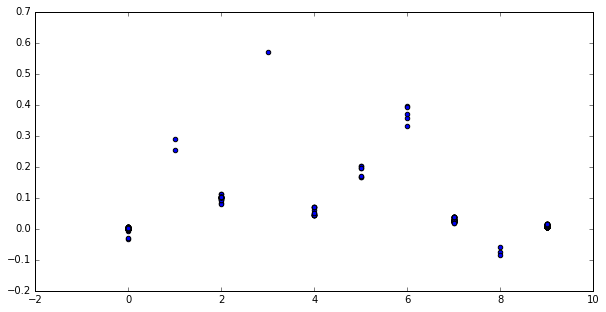

In [267]:
scatter(strategies_performance_df.stats_down_beta_cluster, strategies_performance_df.stats_down_beta)

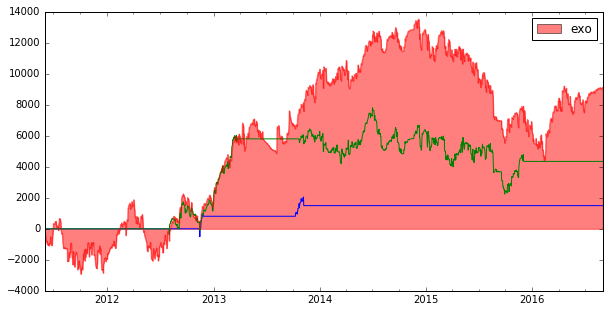

In [269]:
df[strategies_performance_df[strategies_performance_df.stats_up_beta_cluster.isin([2])].index].plot(legend=False)
exo_series.plot(kind='area',legend='EXO', stacked=False)

# Model

In [291]:
dataset = pd.read_csv('cl_callspread_swarms_dataset.csv', index_col=[0])
#dataset = dataset.drop(['stats_pricechange_modsharpe','stats_profit_factor','stats_recovery_factor'], 1)

train_features = dataset.drop('rating', 1)
train_target = dataset.rating

test_features = strategies_performance_df[strategies_performance_df.rating == 0].drop('rating', 1)

In [292]:
#model = linear_model.LogisticRegressionCV(Cs=[0.01,0.1,1,10])
#model = linear_model.LogisticRegressionCV(Cs=[10])
#model = neighbors.KNeighborsClassifier(n_neighbors=5)
#model = naive_bayes.GaussianNB()
#model = tree.DecisionTreeClassifier(max_depth=300)
#model = ensemble.RandomForestClassifier(max_depth=3)


logreg = linear_model.LogisticRegressionCV(Cs=[10])
knn = neighbors.KNeighborsClassifier(n_neighbors=7)
gausnb = naive_bayes.GaussianNB()
dt = tree.DecisionTreeClassifier(max_depth=5)
randforest = ensemble.RandomForestClassifier(max_depth=3)

model = ensemble.VotingClassifier(estimators=[('logreg',logreg), ('knn',knn), ('gausnb',gausnb), ('dt',dt), ('randforest',randforest)])

model.fit(train_features, train_target)

VotingClassifier(estimators=[('logreg', LogisticRegressionCV(Cs=[10], class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, v...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))],
         voting='hard', weights=None)

In [293]:
model.score(train_features, train_target)

0.61250000000000004

In [294]:
#model.feature_importances_

In [295]:
cross_validation.cross_val_score(model, train_features, train_target, cv=3).mean()

0.48728558797524318

In [296]:
strategies_performance_df.loc[strategies_performance_df.rating != None , 'rating'] = model.predict(test_features)

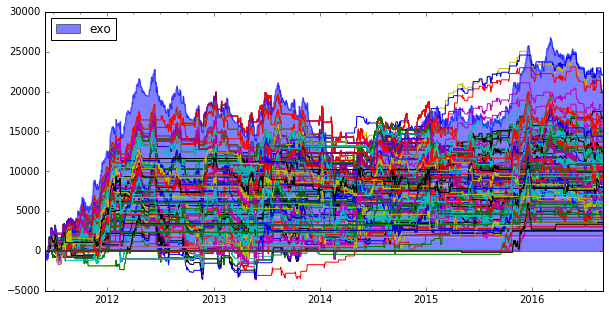

In [297]:
df[strategies_performance_df[strategies_performance_df.rating == 5].index].plot(legend=False)
exo_series.plot(kind='area',legend='EXO', stacked=False)

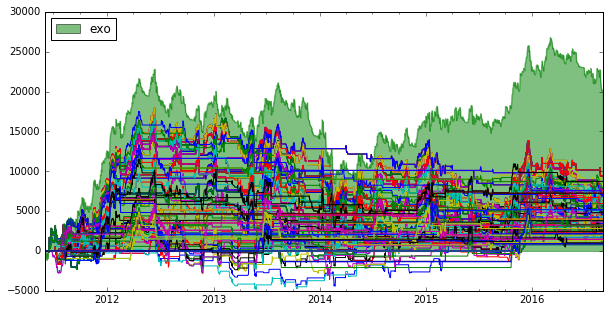

In [298]:
df[strategies_performance_df[strategies_performance_df.rating == 4].index].plot(legend=False)
exo_series.plot(kind='area',legend='EXO', stacked=False)

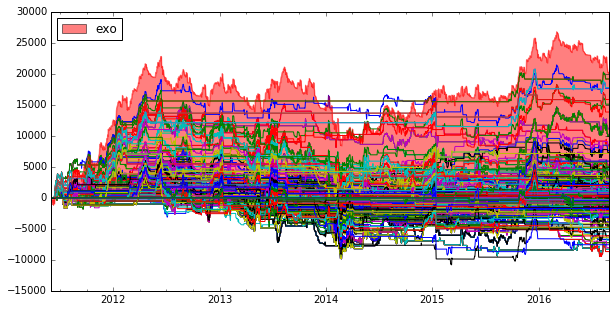

In [299]:
df[strategies_performance_df[strategies_performance_df.rating == 3].index].plot(legend=False)
exo_series.plot(kind='area',legend='EXO', stacked=False)

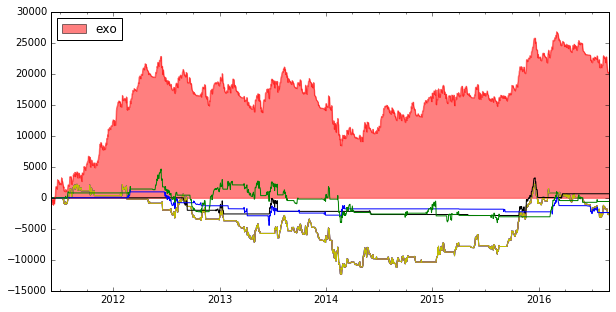

In [300]:
df[strategies_performance_df[strategies_performance_df.rating == 2].index].plot(legend=False)
exo_series.plot(kind='area',legend='EXO', stacked=False)

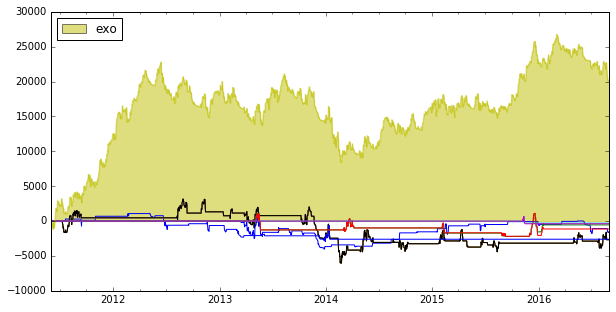

In [301]:
df[strategies_performance_df[strategies_performance_df.rating == 1].index].plot(legend=False)
exo_series.plot(kind='area',legend='EXO', stacked=False)

# Rating and performance metrics dependencies

## X - Predicted rating
## Y - Performance metrics(1 - mod.sharpe, 2 - profit factor, 3 - recovery factor, 4 - betas ratio)

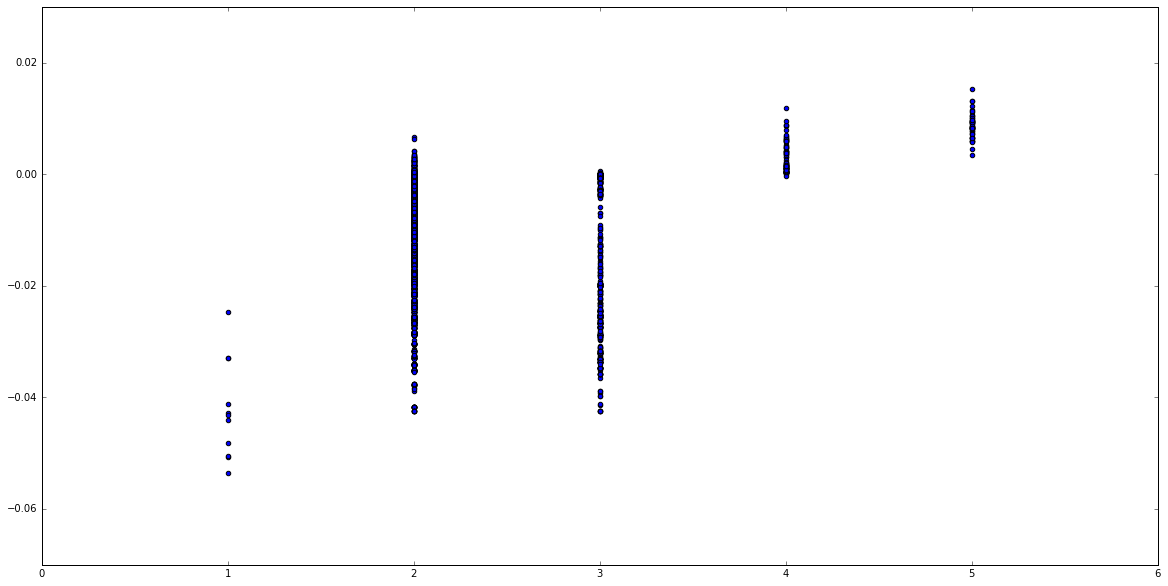

In [43]:
scatter(strategies_performance_df.rating, strategies_performance_df.stats_pricechange_modsharpe)

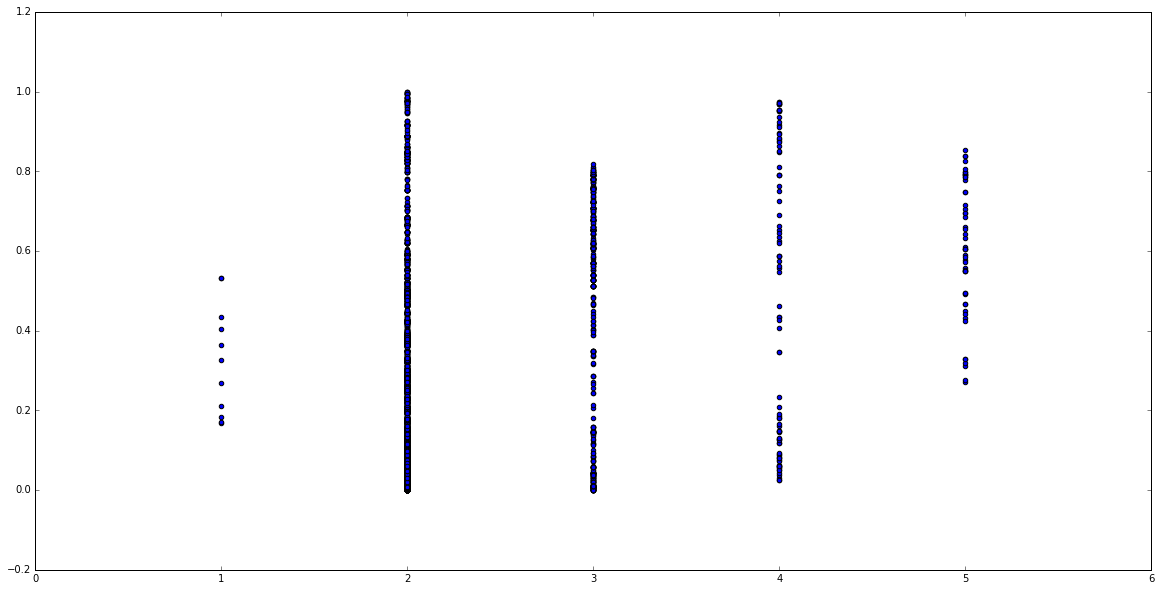

In [44]:
scatter(strategies_performance_df.rating, strategies_performance_df.stats_profit_factor)

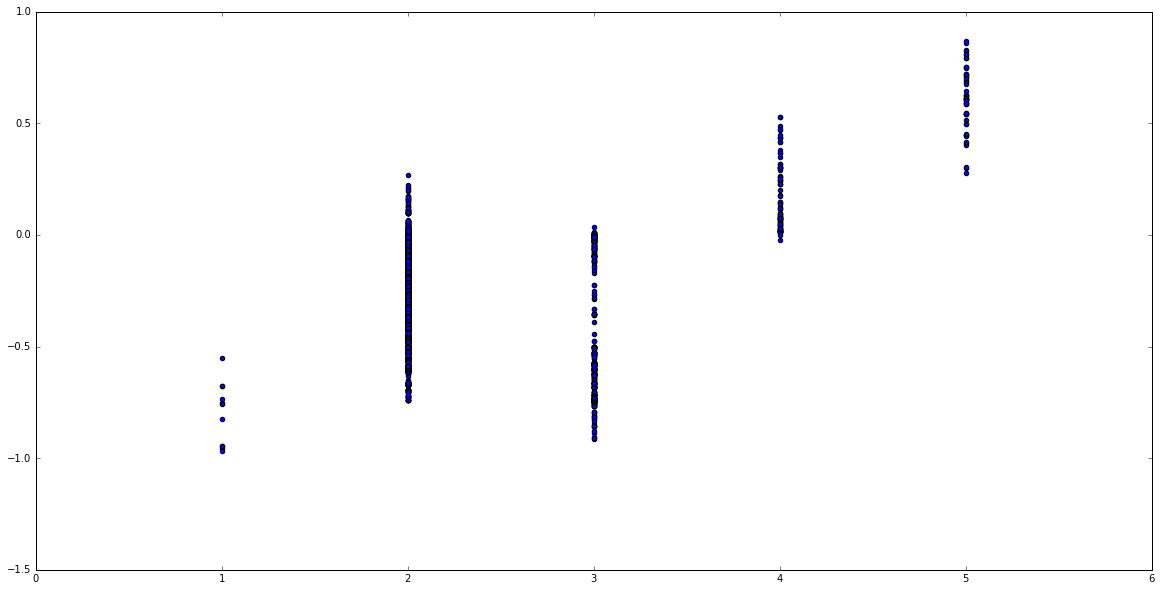

In [45]:
scatter(strategies_performance_df.rating, strategies_performance_df.stats_recovery_factor)

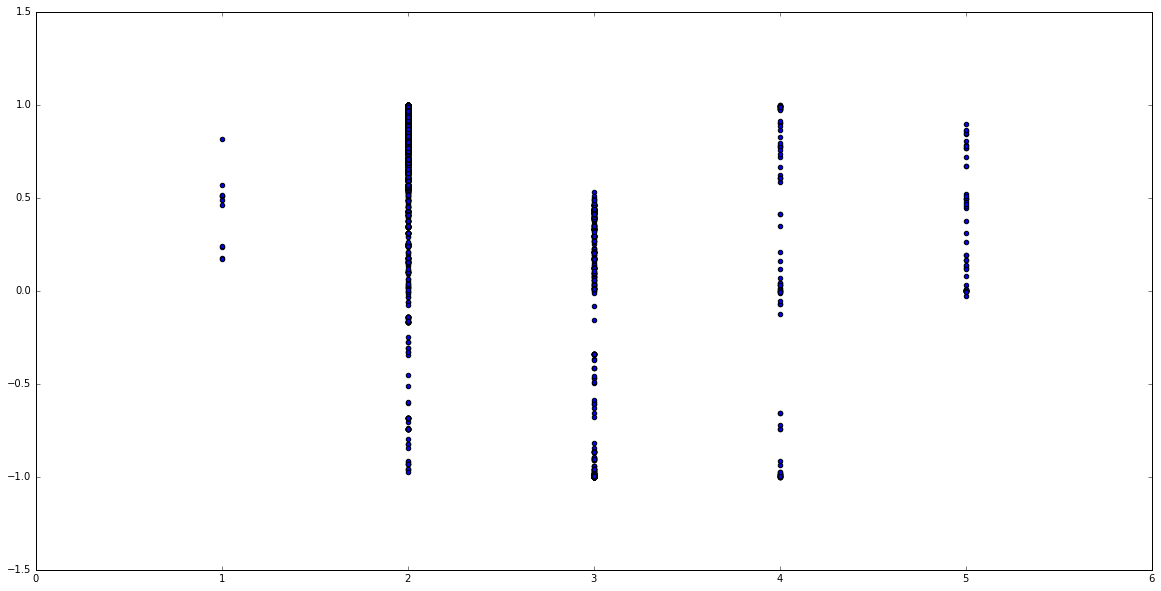

In [46]:
scatter(strategies_performance_df.rating, strategies_performance_df.stats_betas_ratio)

In [49]:
strategies_performance_df.sort_values('rating', ascending=False)
#strategies_performance_df.sort_values('stats_netprofit', ascending=False)

,stats_down_beta,stats_pricechange_modsharpe,stats_profit_factor,stats_recovery_factor,stats_up_beta,rating,stats_betas_ratio
strategy,,,,,,,
CL_CallSpread_Long_BollingerBands,0.046040,-0.014984,0.939292,-0.591127,0.031588,1,0.686102
CL_CallSpread_Long_IchimokuCloud,-1.543100,-0.005267,0.976844,-0.305287,0.207795,1,-0.134661
CL_CallSpread_Long_MACross,0.258261,-0.009342,0.928181,-0.378220,0.735348,1,2.847309
CL_CallSpread_Long_PointAndFigurePatterns,0.309264,-0.020928,0.906181,-0.586961,-0.088406,1,-0.285861
CL_CallSpread_Long_PointAndFigurePatterns_largebox-bearish-custom,0.182699,-0.021754,0.868485,-0.861541,0.042773,1,0.234117
CL_CallSpread_Long_PointAndFigurePatterns_smallbox-bearish-custom,0.014897,0.009603,1.054358,0.739775,0.102388,1,6.872979
CL_CallSpread_Long_RenkoPatterns_no_exit_on_patterns,0.048411,-0.015211,0.922793,-0.498463,0.047750,1,0.986338
CL_CallSpread_Long_SwingPoint,0.041699,-0.039218,0.775518,-0.940264,0.007235,1,0.173497
CL_CallSpread_Long_VolatilityCompression,0.014463,-0.012186,0.933732,-0.416105,0.012744,1,0.881154


## Drop all strategies which have rank score less than n predicted rating

In [50]:
df = df[strategies_performance_df[strategies_performance_df.rating == 5].index]

In [51]:
df.dropna().plot(legend=False)

TypeError: Empty 'DataFrame': no numeric data to plot

## Filter those strategies by correlation

In [52]:
# Rearrange columns from best to worst strategies
df = df.reindex_axis(strategies_performance_df.sort_values('rating', ascending=False).index, axis=1).dropna(axis=1).asfreq(BDay())

In [53]:
df.corr()

""


In [ ]:
corr_df = df.corr()

while_loop_break_flag = False

while True:   
    if while_loop_break_flag == False:
        
        for i in range(len(corr_df)):

            try:       
                strat_corr = corr_df[corr_df.columns[i]]
            
            except IndexError:               
                strat_corr = corr_df[corr_df.columns[-1]]
            
            df = df.drop(strat_corr[(strat_corr.index != strat_corr.name) & (strat_corr >= 0.5)].index, axis=1)

            # Check if previous DF are the same as current DF
            # If they are different - continue the loop

            df_comparison_array = np.array_equal(corr_df,df.corr())
            
            #print(strat_corr[(strat_corr.index != strat_corr.name) & (strat_corr >= 0.5)].index)
            #print(i)
            #print(len(corr_df))
            #print(len(corr_df))
            
            if df_comparison_array  == False and i < len(corr_df):
                corr_df = df.corr()

            elif df_comparison_array  == True and i == len(corr_df)-1:
                while_loop_break_flag = True
                break
                    
    if while_loop_break_flag == True:
        break

In [ ]:
df.corr()

In [ ]:
df.dropna().plot(legend=False)

# Metrics calculation

In [ ]:
#
# Rebalance triggers
#
# Rebalance trigger must be array of Datetime indexes when event occurred, like date of monday or new month
# 
newmonth = df[df.index.month != df.index.shift(1).month].index

monday = df[df.index.weekday == 0].index

norebalance = [df.index[-1]]

newyear = df[df.index.year != df.index.shift(1).year].index
#
#
#

# note: I think more performance metrics for strategies is better
# https://www.amibroker.com/guide/h_report.html for reference

rebalance_index = 1
rebalance_date_start = None

rebalance_trigger = monday # set rebalance trigger here

temp_l = []

for reb_idx in rebalance_trigger:
    
    for strat in df.columns:

        if rebalance_index == 1:
            rebalance_date_start = df.index[0]
           
        for i in range(len(df[strat])):

            if df[strat].index[i] == reb_idx:

                input_strategy_data = df[strat].ix[rebalance_date_start:reb_idx] # This data is used in metrics calc
                
                price_change = input_strategy_data.diff()
                max_dd = (input_strategy_data - input_strategy_data.expanding().max()).min()
                netprofit = df[strat].ix[reb_idx] - df[strat].ix[rebalance_date_start]
                
                # Since swarm PnL statistics is not trade-by-trade
                # For PF calc I used cumulative values of positive and negatives price changes
                # Same for winrate
                profit_factor = price_change[price_change > 0].sum() / np.abs(price_change[price_change < 0].sum())
                
                winrate = (price_change[price_change > 0].count() / price_change.count()) * 100               
                # If all trades are negative, PF is 0. But later all 0s is replaced with NaN. 
                # To avoid replacing true 0.0 PF set it to 0.000001
                # This made for handling missing data 
                
                # Also winrate can be 0.0, but if PF is NaN - no trades were made
                # This made for handling missing data 
                
                if winrate == 0.0 and np.isnan(profit_factor) == False:
                    winrate = 0.000001
                
                elif winrate == 0.0 and np.isnan(profit_factor) == True:
                    winrate = np.nan
                                
                if profit_factor == 0.0:
                    profit_factor = 0.000001                
                          
                try:
                    modsharpe = np.mean(price_change) / np.std(price_change)
                    
                except ZeroDivisionError:
                    modsharpe = np.nan
            
                
                d = {'strategy': strat,'rebalance_date_start': rebalance_date_start,
                    'rebalance_date_end': reb_idx, 'rebalance_index': rebalance_index,
                    'stats_pricechange_modsharpe': modsharpe, 
                    'stats_netprofit': netprofit,
                    'stats_max_dd': max_dd, 'stats_recovery_factor': netprofit / np.abs(max_dd),
                    'stats_profit_factor': profit_factor, 'stats_winrate': winrate, 
                     'equity_below_zero': df[strat].ix[rebalance_date_start] < 0}
                
                '''
                d = {'strategy': strat,'rebalance_date_start': rebalance_date_start,
                    'rebalance_date_end': reb_idx, 'rebalance_index': rebalance_index,
                    'stats_pricechange_modsharpe': modsharpe, 
                    'stats_recovery_factor': netprofit / np.abs(max_dd)}
                '''
                
                temp_l.append(d)
    
    rebalance_index += 1
    rebalance_date_start = reb_idx # set new start rebalance date to current rebalance trigger date

### Data cleaning

In [ ]:
# Replacing 0 values with NaNs
# If strategy stats is 0 means that no trades were made
stats_df = pd.DataFrame(temp_l).replace(0, np.nan)

# Filling NaNs with last avaible values
for s in stats_df.strategy.unique():
    stats_df[stats_df.strategy == s] = stats_df[stats_df.strategy == s].fillna(method='pad')

stats_df = stats_df.dropna(how='any')

In [ ]:
stats_df.tail(10)

## Statistics rank calculation

In [ ]:
ranks_d = {}
ranks_rebidx_d = {}

for i in stats_df.rebalance_index.unique():

    for col in stats_df[stats_df.rebalance_index == i].columns:
        
        stats_col_flag = False
    
        if 'stats' in col:

            # Define 0-10-20-30-40-50-60-70-80-90-100 quantiles values of certain strategy statistics
            metric_quantile0 = stats_df[col].quantile(0.0)
            metric_quantile10 = stats_df[col].quantile(0.1)
            metric_quantile20 = stats_df[col].quantile(0.2)
            metric_quantile30 = stats_df[col].quantile(0.3)
            metric_quantile40 = stats_df[col].quantile(0.4)
            metric_quantile50 = stats_df[col].quantile(0.5)
            metric_quantile60 = stats_df[col].quantile(0.6)
            metric_quantile70 = stats_df[col].quantile(0.7)
            metric_quantile80 = stats_df[col].quantile(0.8)
            metric_quantile90 = stats_df[col].quantile(0.9)
            metric_quantile100 = stats_df[col].quantile(1)

            stats_col_flag = True

        if stats_col_flag == True:
    
            for strat in stats_df[stats_df.rebalance_index == i].strategy:

                # Define strategy statistics rank of certain strategy

                strategy_stats_metric = stats_df[(stats_df.rebalance_index == i) 
                                                 & (stats_df.strategy == strat)][col].values[0]

                if strategy_stats_metric >= metric_quantile0 and strategy_stats_metric <= metric_quantile10:
                    rank_score = 0

                elif strategy_stats_metric >= metric_quantile10 and strategy_stats_metric <= metric_quantile20:
                    rank_score = 1

                elif strategy_stats_metric >= metric_quantile20 and strategy_stats_metric <= metric_quantile30:
                    rank_score = 2

                elif strategy_stats_metric >= metric_quantile30 and strategy_stats_metric <= metric_quantile40:
                    rank_score = 3

                elif strategy_stats_metric >= metric_quantile40 and strategy_stats_metric <= metric_quantile50:
                    rank_score = 4

                elif strategy_stats_metric >= metric_quantile50 and strategy_stats_metric <= metric_quantile60:
                    rank_score = 5

                elif strategy_stats_metric >= metric_quantile60 and strategy_stats_metric <= metric_quantile70:
                    rank_score = 6

                elif strategy_stats_metric >= metric_quantile70 and strategy_stats_metric <= metric_quantile80:
                    rank_score = 7

                elif strategy_stats_metric >= metric_quantile80 and strategy_stats_metric <= metric_quantile90:
                    rank_score = 8

                elif strategy_stats_metric >= metric_quantile90 and strategy_stats_metric <= metric_quantile100:
                    rank_score = 9

                elif strategy_stats_metric == metric_quantile100:
                    rank_score = 10

                    
                if strat not in ranks_d.keys():               
                    ranks_d[strat] = rank_score
                    
                elif strat in ranks_d.keys():                
                    ranks_d[strat] = ranks_d[strat] + rank_score
            #ranks_d['rebalance_idx_'+str(i)] = i

                    
                # For debugging purposes

                #print('strategy---',strat,'\n')
                #print(col)
                #print('10 quantile---',metric_quantile10)
                #print(strategy_stats_metric)
                #print('60 quantile---',metric_quantile60)
                #print(strategy_stats_metric > metric_quantile40 and strategy_stats_metric < metric_quantile50)
                #print('rank_score------', rank_score, '\n')

    
    print('rebalance index ---', i)
    #break
    for k in ranks_d:

        strat_index = stats_df[(stats_df.strategy == k) & ((stats_df.rebalance_index == i))].index
        #print(strat_index)
        stats_df = stats_df.set_value(strat_index, 'rank_score', ranks_d[k])
        
    ranks_d = {}

In [ ]:
stats_df.tail(10)

### Strategies picker

In [ ]:
# Trade-by-trade pnl
pnl_df = df.diff()

summary_best_eqty = pd.Series()
summary_worst_eqty = pd.Series()
benchmark_eqty = pd.Series()

rebalance_history_l = []

# We can set start rebalance index value to 
for i in range(stats_df.rebalance_index.unique().min(),stats_df.rebalance_index.unique().max()):
    
    if i < 2:
        # We must estimate strategies preformance at least on one rebalance window
        continue
        
    else:

        # Pick strats from previous rebalance, but trade them until next rebalance
                        
        start_date = stats_df[stats_df.rebalance_index == i].rebalance_date_start.values[0]  
        end_date = stats_df[stats_df.rebalance_index == i].rebalance_date_end.values[0]
        
        # Number of picked strats defined by .strategy.values[:number]
        # Remove -1 from 'i - 1' to get holy grail :D (future reference)
        
        picked_best_strats = stats_df[(stats_df.rebalance_index == i - 1) & (stats_df.equity_below_zero == False)].sort_values('rank_score', 
                                                                                ascending=False).strategy.values[:3]
        
        picked_worst_strats = stats_df[(stats_df.rebalance_index == i - 1) & (stats_df.equity_below_zero == False)].sort_values('rank_score', 
                                                                                ascending=False).strategy.values[-3:]
        
        all_strats = stats_df[stats_df.rebalance_index == i - 1].sort_values('rank_score', 
                                                                                ascending=False).strategy.values[:]
        
        if len(summary_best_eqty) == 0 and len(summary_worst_eqty) == 0 and len(benchmark_eqty) == 0:
            summary_best_eqty = pnl_df[picked_best_strats].ix[start_date : end_date].sum(axis=1)           
            summary_worst_eqty = pnl_df[picked_worst_strats].ix[start_date : end_date].sum(axis=1)
            
            benchmark_eqty = pnl_df[all_strats].ix[start_date : end_date].sum(axis=1)      
            
        else:
            summary_best_eqty = summary_best_eqty.append(pnl_df[picked_best_strats].ix[start_date : end_date].sum(axis=1))
            summary_worst_eqty = summary_worst_eqty.append(pnl_df[picked_worst_strats].ix[start_date : end_date].sum(axis=1))
            
            benchmark_eqty = benchmark_eqty.append(pnl_df[all_strats].ix[start_date : end_date].sum(axis=1))
        
        d = {'rebalance_index': i, 'best_strategies_list': picked_best_strats}
        
        for s in range(len(picked_best_strats)):
            d['strategy_'+str(s)] = picked_best_strats[s]
        
        rebalance_history_l.append(d)
        
        
best_portfolio = summary_best_eqty.cumsum()
worst_portfolio = summary_worst_eqty.cumsum() * -1 # Reversed

summary_portfolio = best_portfolio + worst_portfolio

benchmark_portfolio = benchmark_eqty.cumsum()

## Comparing portfolios stats with benchmark(all strategies equity)

In [ ]:
def portfolio_stats(portfolio_ser,label):
    input_data = portfolio_ser # This data is used in metrics calc
                
    price_change = input_data.diff()
    max_dd = (input_data - input_data.expanding().max()).min()
    netprofit = input_data.ix[input_data.index[-1]] - input_data.ix[input_data.index[0]]

    # Since swarm PnL statistics is not trade-by-trade
    # For PF calc I used cumulative values of positive and negatives price changes
    # Same for winrate
    profit_factor = price_change[price_change > 0].sum() / np.abs(price_change[price_change < 0].sum())

    winrate = (price_change[price_change > 0].count() / price_change.count()) * 100               

    modsharpe = np.mean(price_change) / np.std(price_change)

    recovery_factor = netprofit / np.abs(max_dd)

    print('Portfolio name ---', str(label))
    print('\n')
    print('PriceChange Mod. Sharpe', modsharpe)
    print('Netprofit',netprofit)
    print('Max DD', max_dd)
    print('Recovery Factor', recovery_factor)
    print('Profit factor', profit_factor)
    print('Winrate', winrate)

    input_data.plot(kind='area', stacked=False)

In [ ]:
portfolio_stats(best_portfolio, 'Best')

In [ ]:
portfolio_stats(worst_portfolio, 'Worst(reversed)')

In [ ]:
portfolio_stats(summary_portfolio, 'Summary(Best + Worst)')

In [ ]:
portfolio_stats(benchmark_portfolio, 'Benchmark(Trade all strategies)')

In [ ]:
portfolio_stats(swarm.picked_equity, 'Picked swarm with current approach')